In [1]:
!pip3 install http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

    100% |████████████████████████████████| 538.9MB 42.2MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5bf8a000 @  0x7f9bea6a01c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 4.0MB/s 
    100% |████████████████████████████████| 2.0MB 9.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# load CIFAR-10 train and test datasets

train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [0]:
# set seeds

torch.manual_seed(1)

if torch.cuda.is_available():
    torch.cuda.manual_seed(1)

In [0]:
class VAE(nn.Module):
    
    def __init__(self):
        
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(28 * 28, 128)
        
        # Latent space
        self.fc2a = nn.Linear(128, 50)
        self.fc2b = nn.Linear(128, 50)
        
        # Decoder
        self.fc3 = nn.Linear(50, 128)
        self.fc4 = nn.Linear(128, 28 * 28)
        
    def forward(self, x):
      
        # Encoding
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc1(out))
        
        # Latent space
        mu = self.fc2a(out)
        logvar = self.fc2b(out)
        
        # Reparameterization
        if self.training:
          
            # get the standard deviation
            std = logvar.mul(0.5).exp_()
            
            # create a standard normal with the above standard deviation
            eps = Variable(std.data.new(std.size()).normal_())
            
            # add the mean to get the encoder distribution
            z = eps.mul(std).add_(mu)
        
        else:
            
            z = mu
            
        # Decoding
        out = F.relu(self.fc3(z))
        out = F.relu(self.fc4(out))
        out = F.sigmoid(out)
        out = out.view(out.size(0), 1, 28, 28)
        
        return out, mu, logvar

In [309]:
# create a model of the VAE
vae = VAE()

# use if GPU available 
if torch.cuda.is_available():
    vae = vae.cuda()
    
vae    

VAE(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2a): Linear(in_features=128, out_features=50, bias=True)
  (fc2b): Linear(in_features=128, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
)

In [0]:
# set the optimizer
optimizer = optim.RMSprop(vae.parameters(), lr=0.01, alpha=0.99, eps=1e-08)

# define the loss function
def loss_function(recon_x, x, mu, logvar):
  
  # binary cross-entropy loss betweeen the reconstructed and the original image
  BCE = F.binary_cross_entropy(recon_x.view(-1, 28 * 28), x.view(-1, 28 * 28), size_average=False)
  
  # KL divergence between the encoder distribution and the standard normal prior of the latent variables
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  
  # return combined loss
  return BCE + KLD


 Epoch #15


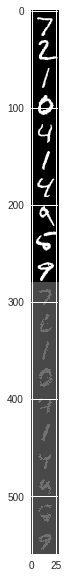

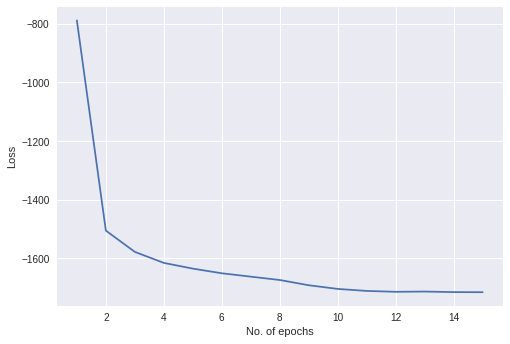

In [311]:
MAX_EPOCHS = 15

loss_arr = []

for epoch in range(1, MAX_EPOCHS + 1):
    
    loss_tot = 0
    
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs
        inputs, _ = data
        
        # use GPU if available
        if torch.cuda.is_available():
            inputs = Variable(inputs.cuda())
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + loss + backward + update
        recon_inputs, mu, logvar = vae(inputs)
        loss = loss_function(recon_inputs, inputs, mu, logvar)
        loss_tot += loss
        loss.backward()
        optimizer.step()
    
    loss_arr.append(float(loss_tot)/float((i+1)*100))
    
    if epoch%MAX_EPOCHS == 0:
        print("\n Epoch #" + str(epoch))
    
    for j, data in enumerate(testloader, 0):
      
        # get the inputs
        inputs, _ = data
        
        # use GPU if available
        if torch.cuda.is_available():
            inputs = Variable(inputs.cuda())

        # forward
        recon_inputs, mu, logvar = vae(inputs)
    
        if epoch%MAX_EPOCHS == 0 and j == 0:
        
            compare = torch.cat([inputs[:10], recon_inputs[:10]])
        
            fig, ax = plt.subplots(1, 1, figsize=(10,10))
            ax.imshow(np.reshape(compare.data.cpu().numpy(), (560,28)), cmap='gray')
            plt.show()
            
plt.plot(range(1, MAX_EPOCHS + 1), loss_arr)
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.show()

In [0]:
del vae
del trainset
del trainloader
del testset
del testloader